In [1]:
from qiskit import IBMQ

IBMQ.load_account()

%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from qiskit.circuit.library.standard_gates import RYGate
from qiskit.circuit import Parameter

In [2]:
provider = IBMQ.load_account()

from qiskit import QuantumCircuit, IBMQ, execute, Aer, QuantumRegister, ClassicalRegister 
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor,backend_overview 
from qiskit.visualization import plot_histogram
import math 

ibmqfactory.load_account:WARNING:2022-05-15 10:18:00,863: Credentials are already in use. The existing account in the session will be replaced.


Amplitudes: 
0.009
0.001
0.017
0.001
0.026
0.085
0.004
0.038
0.026
0.009
0.026
0.067
0.085
0.052
0.085
0.009
0.004
0.009
0.067
0.017
0.038
0.004
0.038
0.017
0.009
0.009
0.067
0.009
0.004
0.052
0.085
0.026
Key
30.83828789021855

Angles: 
0.6763
0.8153
0.7581
0.9187
0.8009
0.7052
0.7975
0.7935
0.5234
0.8506
0.6396
0.9275
0.7518
0.8957
0.8165
0.3162
0.2425
0.8742
0.9487
0.5145
0.848
0.6139
0.3162
0.8321
0.4472
0.3162
0.5547
0.7071
0.3511
0.9615
0.4856
Levels:
0
1
1
2
2
2
2
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4


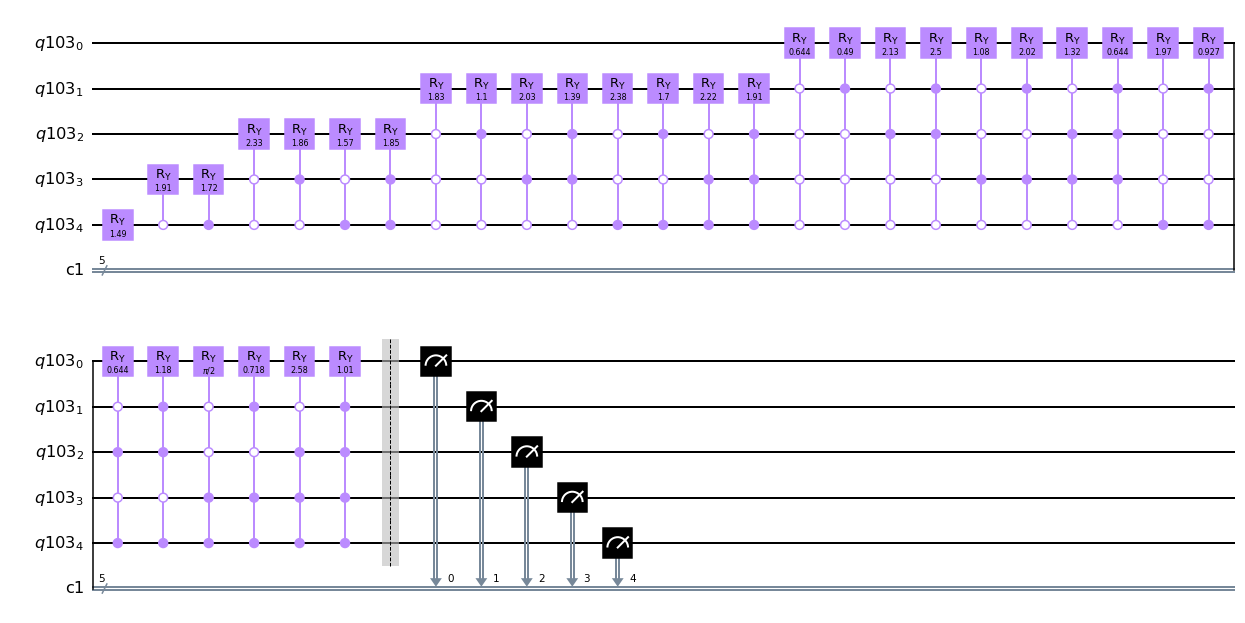

In [5]:
def parabola(l):
    data_ = []
    for i in range(l):
        value = math.pow(l/2, 2) - math.pow(abs(i - l/2), 2)
        print(value)
        data_.append(value)
    return data_
    
def sine(l):
    data_ = []
    for i in range(l):
        value = 1 + math.sin(((i/(l/720)) / 180) * math.pi)
        print(value)
        data_.append(value)
    return data_

def pi(l):
    the_pi = "3141592653589793238462643383279502884197169399375105820974944592307816406286208998628034825342117067982148086513282306647093844609550582231725359408128481117450284102701938521105559644622948954930381964428810975665933446128475648233786783165271201909145648566923460348610454326648213393607260249141273724587006606315588174881520920962829254091715364367892590360011330530548820466521384146951941511609433057270365759591953092186117381932611793105118548074462379962749567351885752724891227938183011949129833673362440656643086021394946395224737190702179860943702770539217176293176752384674818467669405132000568127145263560827785771342757789609173637178721468440901224953430146549585371050792279689258923542019956112129021960864034418159813629774771309960518707211349999998372978049951059731732816096318595024459455346908302642522308253344685035261931188171010003137838752886587533208381420617177669147303598253490428755468731159562863882353787593751957781857780532171226806613001927876611195909216420198938095257201065485863278865936153381827968230301952035301852968995773622599413891249721775283479131515574857242454150695950829533116861727855889075098381754637464939319255060400927701671139009848824012858361603563707660104710181942955596198946767"
    data_ = []
    for i in range(l):
        value = int(the_pi[i])
        data_.append(value)
    return data_
    

def normalizeData(data_points):
    divider = 0
    sum = 0
    print("Amplitudes: ")
    for point in data_points:
        divider += math.pow(point, 2)
    divider = math.sqrt(divider)
    normalized = []
    for i in range(len(data_points)):
        x = data_points[i] / divider
        x2 = math.pow(data_points[i] / divider, 2)
        print(round(x2, 3))
        sum += x2
        normalized.append(x)
    
    return (normalized, divider)

def gen_angles(data):
    if len(data) > 1:
        new_length = int(len(data) / 2)
        new_data = []
        for k in range(new_length):
            new_data.append(math.sqrt(math.pow(data[2*k], 2) + math.pow(data[2*k + 1], 2)))
        
        #print("value")
        #print(new_data)
    
        inner_angles:List[float] = gen_angles(new_data)
    
        angles = []
        
        for k in range(len(new_data)):
            if new_data[k] != 0:
                inside = data[2*k + 1] / new_data[k]
                print(round(inside, 4))
                if (data[2*k] > 0):
                    angles.append(2 * math.asin(inside))
                else:
                    angles.append(2 * math.pi - 2 * math.asin(inside))
            else:
                angles.append(0.0)

        angles = inner_angles + angles
        return angles
    else:
        return []
    
def getCtrlState(level, k):
    ctrl_decimal = int(abs(k - (math.pow(2, level) - 1)))
    ctrl_bin = str(bin(ctrl_decimal))
    ctrl_str = ctrl_bin.split('b')[1].zfill(level)
    ctrl_str = ''.join(reversed(ctrl_str)) ### Reverse because of Qiskit's most significant bit convention 
    return ctrl_str


### Main program 

pi_result = True # change to true if using pi() function
data_length = 32 # this must be powers of two
data_points = pi(data_length) # 2^n long data vector, can also be changed manually or using the test functions

pair = normalizeData(data_points)
data = pair[0]
key = pair[1]

print("Key")
print(key)
print("")
print("Angles: ")
angles = gen_angles(data)

nqubits = int(math.log2(len(data_points)))
nclassical = nqubits
q = QuantumRegister(nqubits)
c = ClassicalRegister(nclassical)
circ = QuantumCircuit(q, c)

a = Parameter('a')
CCRY = RYGate(a).control(2, ctrl_state = '10') # example how to create multi-qubit controlled ry gate

print("Levels:")

for k in range(len(angles)):  
    j = 0
    if (k > 0):
        j = int(math.log2(k + 1)) # level in the binary tree 
    
    print(j)
    
    if (j == 0):
        circ.ry(angles[k], nqubits - 1 - j)
    if (k == 1):
        circ.cry(angles[k], nqubits - 1, nqubits - 1 - j, ctrl_state = 0)
    elif(k == 2):
        circ.cry(angles[k], nqubits - 1, nqubits - 1 - j, ctrl_state = 1)
    elif(k > 2):
        ctrl = getCtrlState(j, k)
        CCRY = RYGate(angles[k]).control(j, ctrl_state = ctrl)
        qubits = []
        for i in range(j + 1):
            qubits.append(nqubits - 1 - i)
        circ.append(CCRY, qubits)
            
    
circ.barrier()
circ.measure(q, c)
circ.draw(output='mpl')

least busy backend:  ibmq_belem
ibmq_belem
Job Status: job has successfully run
Time taken:  0.015774475
00000 | 3.234 
00001 | 0.975 
00010 | 4.166 
00011 | 1.194 
00100 | 4.876 
00101 | 9.004 
00110 | 1.950 
00111 | 5.851 
01000 | 5.183 
01001 | 3.234 
01010 | 5.137 
01011 | 7.892 
01100 | 9.187 
01101 | 7.249 
01110 | 8.585 
01111 | 2.534 
10000 | 1.617 
10001 | 2.715 
10010 | 7.847 
10011 | 3.713 
10100 | 6.011 
10101 | 1.824 
10110 | 6.090 
10111 | 3.839 
11000 | 3.006 
11001 | 3.234 
11010 | 8.375 
11011 | 2.801 
11100 | 2.069 
11101 | 6.650 
11110 | 9.277 
11111 | 5.114 
3.1415926535897932384626433832795


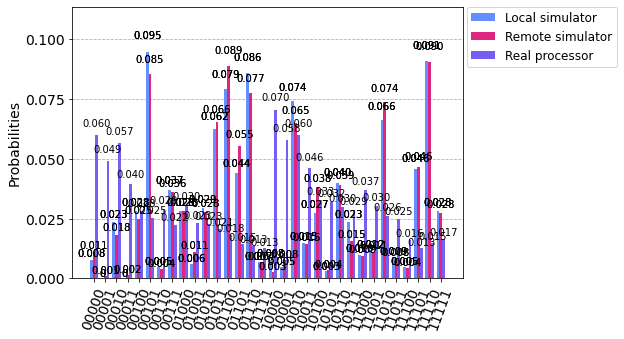

In [6]:


provider = IBMQ.get_provider()
provider.backends() 
local_sim_backend = Aer.get_backend('qasm_simulator') 
sim_backend = provider.get_backend('ibmq_qasm_simulator') 


real_backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))

print("least busy backend: ", real_backend)

print(real_backend) 
job1 = execute(circ,local_sim_backend) 
job2 = execute(circ,sim_backend)
job3 = execute(circ,real_backend)
job_monitor(job3) 

counts1 = job1.result().get_counts()
counts2 = job2.result().get_counts()
counts3 = job3.result().get_counts()  

test_job = job2  # the job which results get printed
test_counts = counts2 # the counts for the same job as above

shots = test_job.result().to_dict()["results"][0]["shots"]
time_taken = test_job.result().time_taken
print("Time taken: ", time_taken)

measured_results = []

binaries = sorted(test_counts.keys())

if (pi_result):
    
    for dict_key in binaries:
        binary_state = dict_key
        print(binary_state, end = ' | ')
        measured_result = math.sqrt(test_counts[''.join(binary_state)] / shots) * key
        measured_results.append(measured_result)
        print("%3.3f" % measured_result, end = ' \n')
        str_result = ""
    
    for k in range(len(measured_results)):
        if (k == 0):
            str_result = str_result + str(round(measured_results[k]))
            str_result = str_result + "." 
        else:
            str_result = str_result + str(round(measured_results[k]))
        
    print(str_result)

legend = ['Local simulator', 'Remote simulator', 'Real processor']
 
circ.draw()

plot_histogram([counts1, counts2, counts3], legend=legend, bar_labels = True)

In [ ]:
the_pi = "3.141592653589793238462643383279502884197169399"